<a href="https://colab.research.google.com/github/isdeniz/msc-2024/blob/main/msc/RoBERTa/roberta_msc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers==4.40.2

In [2]:
pip install simpletransformers==0.64.3

In [3]:
import transformers
>>> transformers.__version__

'4.40.2'

In [4]:
import pandas as pd
from functools import partial
import sklearn
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
import datetime
from sklearn.metrics import confusion_matrix # additional line
import seaborn as sns # additional line
import matplotlib.pyplot as plt # additional line
import torch.multiprocessing # additional line
import os # additional line
os.environ["TOKENIZERS_PARALLELISM"] = "false" # additional line
torch.multiprocessing.set_start_method('spawn', force = True) # additional line
pd.set_option('display.max_colwidth', None)
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
torch.multiprocessing.set_sharing_strategy('file_system')
cuda_available = torch.cuda.is_available()
print("Is cuda available?", cuda_available)

Is cuda available? True


load and prepare data

In [5]:
train = pd.read_csv('data/train_clean_concat_200.csv')
test = pd.read_csv('data/test_clean_concat_200.csv')
print('Number of issues: ', train.shape, test.shape)

Number of issues:  (94185, 2) (10466, 2)


In [6]:
train.head()

,text,labels_cat
0,time 2020-06-01T16:01:49Z author NONE repo Anuken/Mindustry title issue with drillspeed for laserdrills body platform windows 7 build steam build 104.10 issue a water boosted laserdrill on sand displays 4.94 s but it can't supply 8 oil extractors wich only need 4.8 sand s in total. there is no overflowing sand and the oil lake on the last extractor is smaller compared to the others. for smooth designs it would be nice to get the actuall 4.94 s out of that drill image https user images.githubusercontent.com 66265700 83427216 ac0add00 a430 11ea 9ea5 026092d03b3e.png place an x no spaces between the brackets to confirm that you have read the line below. x i have searched the closed and open issues to make sure that this problem has not already been reported.,0
1,time 2020-06-03T11:25:20Z author CONTRIBUTOR repo Anuken/Mindustry title anti virus program was blocking game body platform windows 10 build 104.10 issue see screenshot image https user images.githubusercontent.com 44261958 83630982 b5827980 a5d7 11ea 8776 37f92c35799a.png download from itch.io steps to reproduce run mindustry.exe link to function used if applicable vanilla crash report if applicable nothing place an x no spaces between the brackets to confirm that you have read the line below. x i have searched the closed and open issues to make sure that this problem has not already been reported.,0
2,time 2020-06-03T14:27:30Z author CONTRIBUTOR repo Anuken/Mindustry title game crashes with a nonexistent item name in the itemdrop key in an ore. body platform android ios mac windows linux linux build the build number under the title in the main menu. required. 104.10 issue explain your issue in detail. my bug report isn't really a bug but it causes the game to crash every time you open it until you delete it out of your mod folder. the bug is that if you have an ore which has the code type oreblock itemdrop put a nonexistent item name here steps to reproduce how you happened across the issue and what you were doing at the time. create a basic mod with only a mod.json and content folder then create a blocks folder in the content folder and link to function used if applicable the mod repositories or zip files that are related to the issue. nichrosia bugtest crash report if applicable the contents of relevant crash report files. crash report is in the repository place an x no spaces between the brackets to confirm that you have read the line below. x i,0
3,time 2020-06-03T17:50:49Z author NONE repo Anuken/Mindustry title graphical bug with legged units body platform windows build latest bleeding edge issue there's a graphical bug where the cix's body will render on top of a ground unit but its legs will render underneath it making the unit look like it's floating and overall looking strange. steps to reproduce create a cix control it and walk over a ground unit. place an x no spaces between the brackets to confirm that you have read the line below. x i have searched the closed and open issues to make sure that this problem has not already been reported.,0
4,time 2020-06-06T11:06:07Z author NONE repo Anuken/Mindustry title multiplayer incompatibilities due to mismatched versions posted on different platforms body platform android ios steam build android 104.6 ios 104.4 steam 104.10 issue trying to play multiplayer cross platform with my friend is impossible due to the build mismatches explained above. steps to reproduce download the app from ios and get the version stated directly from the app store. download the steam version and get the version stated directly from steam. optional download the android version and get the version stated directly from android. attempt to play multiplayer with the other platforms locally or not. link to function used if applicable this is not a mod issue. crash report if applicable there are no logs this is an issue with a version mismatch. edit removed an extra on the platform section. place an x no spaces between the brac

In [7]:
test.head()

,text,labels_cat
0,time 2019-10-31T02:23:02Z author CONTRIBUTOR repo grpc/grpc-java title propose to officially support arm64 platform body please answer these questions before submitting a feature request. is your feature request related to a problem? a clear and concise description of what the problem is. ex. i'm always frustrated when ... yes recently i am working on promoting hadoop building on arm64 server while an error occured due to missing the io.grpc protoc gen grpc java exe linux aarch_64 1.15.1 artifact for aarch platform see error messages info info build failure info info total time 03 13 min info finished at 2019 05 17t09 28 55 08 00 info error failed to execute goal org.xolstice.maven.plugins protobuf maven plugin 0.5.1 compile custom default on project hadoop yarn csi missing error error 1 io.grpc protoc gen grpc java exe linux aarch_64 1.15.1 error error try downloading the file manually from the project website. error error then install it using the command error mvn install install file dgroupid io.grpc dartifactid protoc gen grpc java dversion 1.15.1 dclassifier linux aarch_64 dpackaging exe dfile path to file error error alternatively if you host,1
1,time 2018-08-03T12:18:12Z author CONTRIBUTOR repo OpenAPITools/openapi-generator title typescript angular how to customize output filenames? body do someone can help me to customize output files names? given the tag below my resource i want to obtain the output file my resource.service.ts instead of myresource.service.ts given the model below mymodel i want to obtain the output file my model.ts instead of mymodel.ts many thanks for your help,1
2,time 2010-06-01T16:43:42Z author COLLABORATOR repo spring-projects/spring-framework title resourcebundlethemesource should resolve .properties like resourcebundlemessagesource spr 7252 body alvin chee https jira.spring.io secure viewprofile.jspa?name alvincys opened spr 7252 https jira.spring.io browse spr 7252?redirect false and commented if current request context is en_us and no theme_en_us.properties specified or no key specified in theme_en_us.properties it should fallback to theme_en.properties then theme.properties. bean id themesource class org.springframework.ui.context.support.resourcebundlethemesource property name basenameprefix value theme_ bean bean id themeresolver class org.springframework.web.servlet.theme.sessionthemeresolver property name defaultthemename value en_us bean affects 3.0.2 issue links issue resourcebundlethemesource should resolve .properties like resourcebundlemessagesource _ is duplicated by _,1
3,time 2022-05-05T06:18:07Z author MEMBER repo spring-projects/spring-framework title support multiple springfactoriesloader files body for aot we'd like to be able to load a meta inf spring aot.factories files rather than meta inf spring.factories .,1
4,time 2022-01-12T08:42:59Z author NONE repo elastic/elasticsearch title percolate query fvh highlighter does not work on subfields body github is reserved for bug reports and feature requests it is not the place for general questions. if you have a question or an unconfirmed bug please visit the forums https discuss.elastic.co c elasticsearch . please also check your os is supported https www.elastic.co support matrix show_os . if it is not the issue is likely to be closed. for security vulnerabilities please only send reports to security elastic.co. see https www.elastic.co community security for more information. please fill in the following details to help us reproduce the bug elasticsearch version bin elasticsearch version 7.16.2 plugins installed jvm version java version os version uname a if on a unix like system description of the problem including expected versus actual behavior percolated queries no longer highlight subfields with fvh higlighter. i expect them to be highlighted as in the previous version of es. steps to reproduce index mappings with a field and subfield with identical analysis both have term vectors with positions offs

set the classification layer and training parameters

In [8]:
lr = 3e-5
drp = 0
epochs = 4
batch_t = 100
batch_e = 100
max_seq = 200
name = 'roberta'
ver = 'roberta-base'
output_name = 'outputs/' + name

def create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq):
    model_args = ClassificationArgs()
    model_name = name
    model_version = ver
    model_args.learning_rate = lr
    model_args.num_train_epochs = epochs
    model_args.eval_batch_size = batch_t
    model_args.train_batch_size = batch_e
    model_args.max_seq_length = max_seq
    # model_args.n_gpu = 2 below line is added since this line (original) uses 2 GPUs but we have 1
    model_args.n_gpu = 1
    model_args.output_dir = output_name +'/'
    model_args.overwrite_output_dir = True
    model_args.reprocess_input_data = True
    model_args.preprocess_inputs = True
    model_args.save_steps = -1
    model_args.save_model_every_epoch = False

    model = ClassificationModel(model_name, model_version, args = model_args,
                                num_labels = 3,
                                use_cuda=cuda_available)

    return model

define evaluation metrics

In [9]:
def calc(p1, p2, func, **kwargs):
    return func(p1, p2, **kwargs)

metrics_recom = {
    "accuracy": partial(calc,func=sklearn.metrics.accuracy_score) ,
    "p_micro": partial(calc,func=sklearn.metrics.precision_score,average='micro'),
    "p_macro": partial(calc,func=sklearn.metrics.precision_score,average='macro'),
    "p_w": partial(calc,func=sklearn.metrics.precision_score,average='weighted'),
    "r_micro": partial(calc,func=sklearn.metrics.recall_score,average='micro'),
    "r_macro": partial(calc,func=sklearn.metrics.recall_score,average='macro'),
    "r_w": partial(calc,func=sklearn.metrics.recall_score,average='weighted'),
    "f_micro": partial(calc,func=sklearn.metrics.f1_score,average='micro'),
    "f_macro": partial(calc,func=sklearn.metrics.f1_score,average='macro'),
    "f_w": partial(calc,func=sklearn.metrics.f1_score,average='weighted'),
    "classificationReport": partial(calc,func=sklearn.metrics.classification_report, output_dict=True)
}

train the model

In [10]:
model = create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq)
start = datetime.datetime.now()
print('-'*5,  name, ', start time:',
datetime.datetime.strftime(datetime.datetime.today(), '%d/%m/%Y-%H:%M'), '-'*5)
model.train_model(train_df=train, **metrics_recom)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

----- roberta , start time: 15/08/2024-11:36 -----


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/94185 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/942 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/942 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/942 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/942 [00:00<?, ?it/s]

(3768, 0.3364306991749825)

evaluate the model

In [11]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results, model_outputs, wrong_pred = model.eval_model(test, verbose=True, **metrics_recom)
results

----- roberta , duration is: 0h:11m:13s ----- 




/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/10466 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

{'mcc': 0.7956273185614943,
 'accuracy': 0.8826676858398624,
 'p_micro': 0.8826676858398624,
 'p_macro': 0.8625929355293144,
 'p_w': 0.8813804363570125,
 'r_micro': 0.8826676858398624,
 'r_macro': 0.8370345294369144,
 'r_w': 0.8826676858398624,
 'f_micro': 0.8826676858398624,
 'f_macro': 0.848696015353247,
 'f_w': 0.8815084102817712,
 'classificationReport': {'0.0': {'precision': 0.8956822107081175,
   'recall': 0.926899016979446,
   'f1-score': 0.9110232762406676,
   'support': 5595.0},
  '1.0': {'precision': 0.8843689049874617,
   'recall': 0.8726972779763541,
   'f1-score': 0.8784943260448381,
   'support': 3637.0},
  '2.0': {'precision': 0.8077276908923643,
   'recall': 0.7115072933549432,
   'f1-score': 0.7565704437742351,
   'support': 1234.0},
  'accuracy': 0.8826676858398624,
  'macro avg': {'precision': 0.8625929355293144,
   'recall': 0.8370345294369144,
   'f1-score': 0.848696015353247,
   'support': 10466.0},
  'weighted avg': {'precision': 0.8813804363570125,
   'recall': 

get the confusion matrix

In [12]:
model_outputs_df = pd.DataFrame(model_outputs, columns = ['bug', 'enhancement', 'question'])

In [13]:
def get_prediction(row):
  max_value = row.max()
  if max_value == row['bug']:
    return 0
  elif max_value == row['enhancement']:
    return 1
  elif max_value == row['question']:
    return 2

In [14]:
model_outputs_df['prediction'] = model_outputs_df.apply(get_prediction, axis = 1)

In [16]:
model_outputs_df['actual'] = test['labels_cat']

In [17]:
label_names = ['bug', 'enhancement', 'question']

In [18]:
predicted_labels = model_outputs_df['prediction']
actual_labels = model_outputs_df['actual']

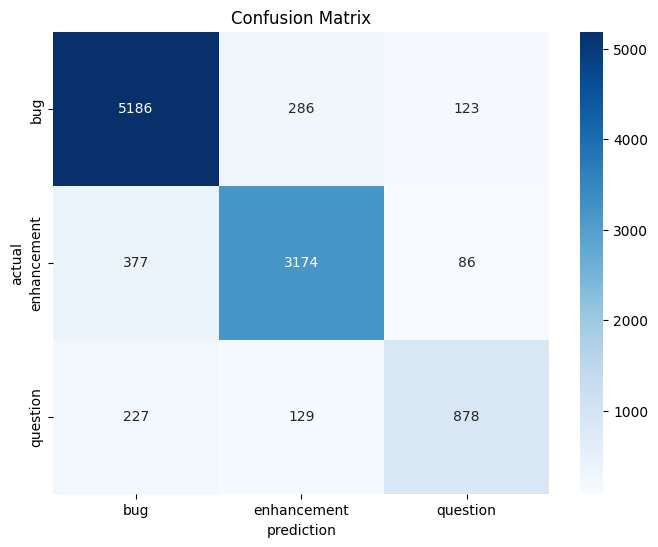

In [19]:
confusion_matrix = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

save predictions

In [20]:
predictions = pd.DataFrame(columns = ['text', 'labels', 'actual_labels', 'prediction'])

In [21]:
predictions['text'] = test['text']
predictions['labels'] = test['labels_cat']
predictions['actual_labels'] = model_outputs_df['actual']
predictions['prediction'] = model_outputs_df['prediction']
predictions.head()

,text,labels,actual_labels,prediction
0,time 2019-10-31T02:23:02Z author CONTRIBUTOR repo grpc/grpc-java title propose to officially support arm64 platform body please answer these questions before submitting a feature request. is your feature request related to a problem? a clear and concise description of what the problem is. ex. i'm always frustrated when ... yes recently i am working on promoting hadoop building on arm64 server while an error occured due to missing the io.grpc protoc gen grpc java exe linux aarch_64 1.15.1 artifact for aarch platform see error messages info info build failure info info total time 03 13 min info finished at 2019 05 17t09 28 55 08 00 info error failed to execute goal org.xolstice.maven.plugins protobuf maven plugin 0.5.1 compile custom default on project hadoop yarn csi missing error error 1 io.grpc protoc gen grpc java exe linux aarch_64 1.15.1 error error try downloading the file manually from the project website. error error then install it using the command error mvn install install file dgroupid io.grpc dartifactid protoc gen grpc java dversion 1.15.1 dclassifier linux aarch_64 dpackaging exe dfile path to file error error alternatively if you host,1,1,1
1,time 2018-08-03T12:18:12Z author CONTRIBUTOR repo OpenAPITools/openapi-generator title typescript angular how to customize output filenames? body do someone can help me to customize output files names? given the tag below my resource i want to obtain the output file my resource.service.ts instead of myresource.service.ts given the model below mymodel i want to obtain the output file my model.ts instead of mymodel.ts many thanks for your help,1,1,1
2,time 2010-06-01T16:43:42Z author COLLABORATOR repo spring-projects/spring-framework title resourcebundlethemesource should resolve .properties like resourcebundlemessagesource spr 7252 body alvin chee https jira.spring.io secure viewprofile.jspa?name alvincys opened spr 7252 https jira.spring.io browse spr 7252?redirect false and commented if current request context is en_us and no theme_en_us.properties specified or no key specified in theme_en_us.properties it should fallback to theme_en.properties then theme.properties. bean id themesource class org.springframework.ui.context.support.resourcebundlethemesource property name basenameprefix value theme_ bean bean id themeresolver class org.springframework.web.servlet.theme.sessionthemeresolver property name defaultthemename value en_us bean affects 3.0.2 issue links issue resourcebundlethemesource should resolve .properties like resourcebundlemessagesource _ is duplicated by _,1,1,1
3,time 2022-05-05T06:18:07Z author MEMBER repo spring-projects/spring-framework title support multiple springfactoriesloader files body for aot we'd like to be able to load a meta inf spring aot.factories files rather than meta inf spring.factories .,1,1,1
4,time 2022-01-12T08:42:59Z author NONE repo elastic/elasticsearch title percolate query fvh highlighter does not work on subfields body github is reserved for bug reports and feature requests it is not the place for general questions. if you have a question or an unconfirmed bug please visit the forums https discuss.elastic.co c elasticsearch . please also check your os is supported https www.elastic.co support matrix show_os . if it is not the issue is likely to be closed. for security vulnerabilities please only send reports to security elastic.co. see https www.elastic.co community security for more information. please fill in the following details to help us reproduce the bug elasticsearch version bin elasticsearch version 7.16.2 plugins installed jvm version java version os version uname a if on a unix like system description of the problem including expected versus actual behavior percolated queries no longer highlight subfields with fvh higlighter. i expect them to be highlighted as in the previous version of es. steps to reproduce index mappings with a field and subfield with identical analysis both 

In [22]:
predictions.to_csv('data/msc_test_roberta_preds.csv')

In [23]:
predictions.to_pickle('data/msc_test_roberta_preds.pkl')